# Renewable Energy Prediction
Data from: https://data.open-power-system-data.org/

A key goal of smart grid initiatives is significantly increasing the fraction of grid energy contributed by renewables. One challenge with integrating renewables into the grid is that their power generation is intermittent and uncontrollable. Thus, predicting future renewable generation is important, since the grid must dispatch generators to satisfy demand as generation varies. This is the goal of our project

# Data Import and Clearning

In [1067]:
#Importing libraries for visualization, graphs, and modeling
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set()
from pylab import *
from scipy import special, optimize
import sys
import os
pd.set_option('display.max_columns', None)


In [1068]:
robbie_filepath_prod = "/Users/robertprior/Desktop/ML Projects/Final Project/time_series_60min_singleindex.csv"
robbie_filepath_w = "/Users/robertprior/Desktop/ML Projects/Final Project/weather_data.csv"

lindsey_filepath_prod = "/Users/LindseyTakeuchi/Downloads/time_series_60min_singleindex (1).csv"
lindsey_filepath_w = "/Users/LindseyTakeuchi/Downloads/weather_data.csv"

#collin_filepath_prod =
#collin_filepath_w =

In [1069]:
#Robbie
prod = pd.read_csv(robbie_filepath_prod, usecols=(lambda s: s.startswith('utc') | s.startswith('DE')), parse_dates=[0], index_col=0)
weather = pd.read_csv(robbie_filepath_w, parse_dates=[0], index_col=0)


In [1070]:
#lindsey
#prod = pd.read_csv(lindsey_filepath_prod, usecols=(lambda s: s.startswith('utc') | s.startswith('DE')), parse_dates=[0], index_col=0)
#weather = pd.read_csv(lindsey_filepath_w, parse_dates=[0], index_col=0)


In [1071]:
#Collin
#prod = pd.read_csv(collin_filepath_prod,usecols=(lambda s: s.startswith('utc') | s.startswith('DE')), parse_dates=[0], index_col=0)
#weather = pd.read_csv(collin_filepath_w, parse_dates=[0], index_col=0)

Electricity production first

In [1072]:
#our prediction will be focused on just these two electricity generation columns
prod = prod[['DE_wind_generation_actual','DE_solar_generation_actual']]

In [1073]:
prod.head()

,DE_wind_generation_actual,DE_solar_generation_actual
utc_timestamp,,
2005-12-31 23:00:00+00:00,NaN,NaN
2006-01-01 00:00:00+00:00,NaN,NaN
2006-01-01 01:00:00+00:00,NaN,NaN
2006-01-01 02:00:00+00:00,NaN,NaN
2006-01-01 03:00:00+00:00,NaN,NaN


In [1074]:
#We want to separate into separate solar and wind dataframes as they will both be different models
wind_df = pd.DataFrame(prod['DE_wind_generation_actual'])

In [1075]:
solar_df = pd.DataFrame(prod['DE_solar_generation_actual'])

We know we have missing values for these. There is no point in filling them in with the mean for time series as they are our target variable so we will just drop them

In [1076]:
solar_df = solar_df.dropna()

In [1077]:
wind_df = wind_df.dropna()

For the weather dataframe, we will select the aggregated variables of interest and then merge them onto the solar and wind dataframes

In [1078]:
#We want just to just use these columns for weather as these were the aggregated scores for the country
weather = weather[['DE_windspeed_10m', 'DE_temperature', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal']]

In [1079]:
#Lets put this weather data onto each of our electricity generation datasets
solar_df = solar_df.merge(weather, left_on=['utc_timestamp'], right_on=['utc_timestamp'], how='left')

In [1080]:
wind_df = wind_df.merge(weather, left_on=['utc_timestamp'], right_on=['utc_timestamp'], how='left')

In [1081]:
#lets see if there are any missing values for the weather that does not match up to the target variables
solar_df.isnull().sum()

DE_solar_generation_actual             0
DE_windspeed_10m                   10274
DE_temperature                     10274
DE_radiation_direct_horizontal     10274
DE_radiation_diffuse_horizontal    10274
dtype: int64

So it appears that there are missing weather values for certain dates. Since we are using two different models, with one of the models named Prophet not using weather data, lets copy these datasets into new datasets ready for the Prophet model.

In [1082]:
#making separate dfs for the prophet model later which will not use weather data and so the missing weather data is 
#not an issue
wind_prophet = pd.DataFrame(wind_df.copy())
solar_prophet = pd.DataFrame(solar_df.copy())

In [1083]:
solar_prophet.head()

,DE_solar_generation_actual,DE_windspeed_10m,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal
utc_timestamp,,,,,
2011-12-31 23:00:00+00:00,0.0,4.6216,4.694,0.0,0.0
2012-01-01 00:00:00+00:00,0.0,4.8564,4.951,0.0,0.0
2012-01-01 01:00:00+00:00,0.0,5.0145,5.200,0.0,0.0
2012-01-01 02:00:00+00:00,0.0,5.2142,5.468,0.0,0.0
2012-01-01 03:00:00+00:00,0.0,5.4012,5.767,0.0,0.0


#### Creating lagged measures for solar and wind of the pertinent weather column to be used in predicting hourly short term

In [1084]:
#function for the lag variables
def buildLaggedFeatures(s,lag=2,dropna=True):
    '''
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for col_name in s:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res 

I now want to see which variable should be used as an extra regressor using a correlation matrix for each

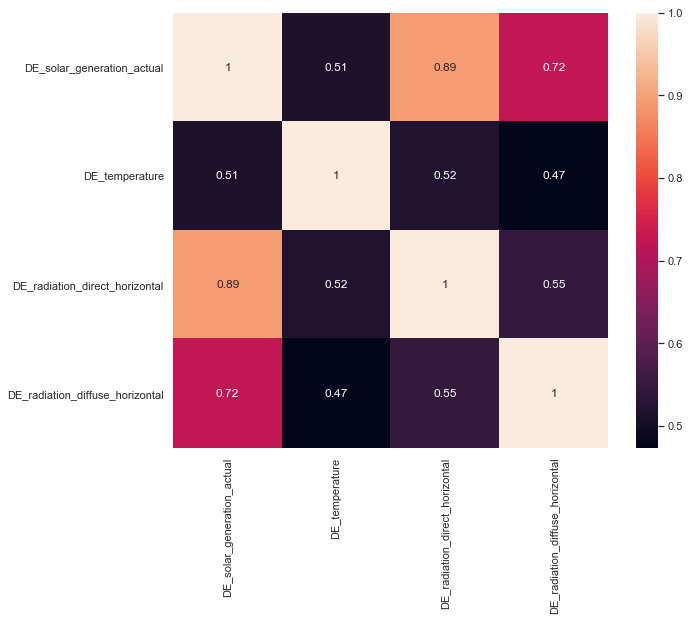

In [1085]:
correlation_sp = solar_prophet.corr()
PovertyLevelCorr = correlation_sp.index[abs(correlation_sp['DE_solar_generation_actual'])>.3]
f, ax=plt.subplots(figsize=(10,8))
sns.heatmap(solar_prophet[PovertyLevelCorr].corr(), square=True, annot=True)

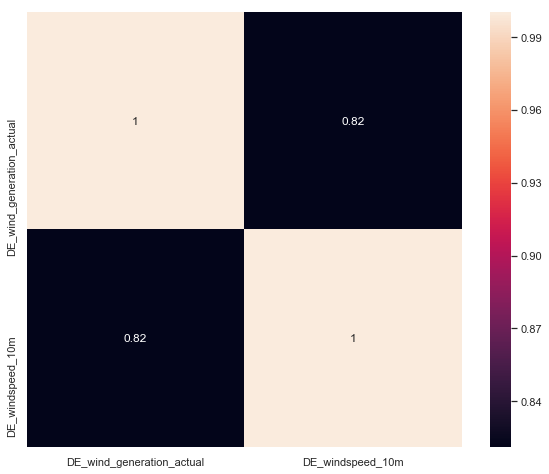

In [1086]:
correlation_sp = wind_prophet.corr()
PovertyLevelCorr = correlation_sp.index[abs(correlation_sp['DE_wind_generation_actual'])>.3]
f, ax=plt.subplots(figsize=(10,8))
sns.heatmap(wind_prophet[PovertyLevelCorr].corr(), square=True, annot=True)

So for wind I will use DE_windspeed_10m and for solar I will use DE_radiation_direct_horizontal

In [1087]:
#creating the lagged variables
solar_lag = buildLaggedFeatures(solar_prophet['DE_radiation_direct_horizontal'], lag=24, dropna=False)

In [1088]:
#selecting just my 24 hour lag because we forecast will just be 24 hours
solar_lag = pd.DataFrame(solar_lag['lag_24'])

In [1089]:
solar_prophet = pd.concat([solar_prophet, solar_lag], axis=1)

In [1090]:
solar_prophet.tail()

,DE_solar_generation_actual,DE_windspeed_10m,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,lag_24
utc_timestamp,,,,,,
2018-03-05 18:00:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN
2018-03-05 19:00:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN
2018-03-05 20:00:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN
2018-03-05 21:00:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN
2018-03-05 22:00:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN


now the same thing but for wind

In [1091]:
#creating the lagged variables
wind_lag = buildLaggedFeatures(wind_prophet['DE_windspeed_10m'], lag=24, dropna=False)

In [1092]:
#selecting just my 24 hour lag because we forecast will just be 24 hours
wind_lag = pd.DataFrame(wind_lag['lag_24'])

In [1093]:
wind_prophet = pd.concat([wind_prophet, wind_lag], axis=1)

Now that the prophet dataframes are done, let's look at the non-Prophet dataframes to see what's best for handling these missing values

In [1094]:
#the missing values are all missing for the same rows and since we can't make a prediction without it we will just drop
#all these columns with missing data
solar_df = solar_df.dropna()
wind_df = wind_df.dropna()

# Pre-Modeling 
Getting the data ready to model



### Dataset Cleaning for Prophet
for the long term forcasting (daily), there is actually no data cleaning that needs to be done besides getting the datasets in the right format. The short term prophet data will require cleaning. We are looking to just drop the data with missing weather data as the extra regressor.

#### Short Term forecasting dataset

In [1095]:
solar_prophet_h = []
solar_prophet_h = solar_prophet.copy()
solar_prophet_h = solar_prophet_h['DE_solar_generation_actual']
solar_prophet_h = pd.concat([solar_prophet_h,solar_prophet['lag_24']], axis=1)
solar_prophet_h = pd.DataFrame(solar_prophet_h)
solar_prophet_h['ds'] = solar_prophet_h.index
solar_prophet_h.columns = ['y', 'weather', 'ds']
solar_prophet_h['ds'] = solar_prophet_h['ds'].dt.tz_convert(None)
solar_prophet_h = solar_prophet_h.reset_index(drop=True)
solar_prophet_h = solar_prophet_h.dropna()
solar_prophet_h.tail()

,y,weather,ds
43827,0.0,0.0,2017-01-01 19:00:00
43828,0.0,0.0,2017-01-01 20:00:00
43829,0.0,0.0,2017-01-01 21:00:00
43830,0.0,0.0,2017-01-01 22:00:00
43831,0.0,0.0,2017-01-01 23:00:00


In [1096]:
wind_prophet_h = []
wind_prophet_h = wind_prophet.copy()
wind_prophet_h = wind_prophet_h['DE_wind_generation_actual']
wind_prophet_h = pd.concat([wind_prophet_h,wind_prophet['lag_24']], axis=1)
wind_prophet_h = pd.DataFrame(wind_prophet_h)
wind_prophet_h['ds'] = wind_prophet_h.index
wind_prophet_h.columns = ['y', 'weather', 'ds']
wind_prophet_h['ds'] = wind_prophet_h['ds'].dt.tz_convert(None)
wind_prophet_h = wind_prophet_h.reset_index(drop=True)
wind_prophet_h = wind_prophet_h.dropna()
wind_prophet_h.tail()

,y,weather,ds
61387,11094.0,4.2129,2017-01-01 19:00:00
61388,11533.0,4.2875,2017-01-01 20:00:00
61389,12339.0,4.2965,2017-01-01 21:00:00
61390,12260.0,4.4200,2017-01-01 22:00:00
61391,12389.0,4.4611,2017-01-01 23:00:00


#### Long Term Forecasting dataset

/anaconda3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


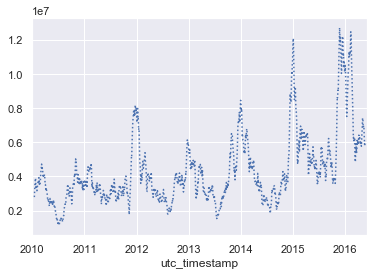

In [1097]:
#first the wind dataset
daily_w =  wind_prophet['DE_wind_generation_actual']
#deleting the test section from the dataset
daily_w = daily_w[daily_w.index<'2016-06-01 01:00:00']
daily_w =  daily_w.resample('D').sum()

#let's plot this daily wind electricity generation to get a feel of where our model will need to be adjusted
daily_w.rolling(30, center=True).sum().plot(style=[':', '--', '-'])

From this, it appears that the majority of the variation is coming from weekly trends and is not as volatile as hourly. Let's prepare the data next for the model



In [1098]:
#preparing our wind data
wind_prophet_d = []
wind_prophet_d = daily_w.copy()
wind_prophet_d = pd.DataFrame(wind_prophet_d)
wind_prophet_d['ds'] = wind_prophet_d.index
wind_prophet_d.columns = ['y', 'ds']
wind_prophet_d['ds'] = wind_prophet_d['ds'].dt.tz_convert(None)
wind_prophet_d = wind_prophet_d.reset_index(drop=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


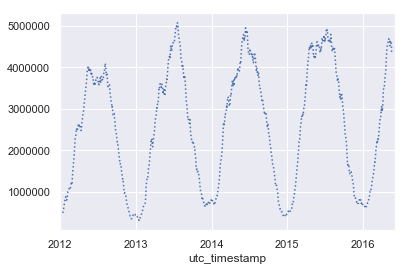

In [1099]:
#now for the solar datset
daily_s =  solar_prophet['DE_solar_generation_actual']
#deleting the test section from the dataset
daily_s = daily_s[daily_s.index<'2016-06-01 01:00:00']
daily_s =  daily_s.resample('D').sum()

daily_s.rolling(30, center=True).sum().plot(style=[':', '--', '-'])



In [1100]:
#setting up our solar data
solar_prophet_d = []
solar_prophet_d = daily_s.copy()
solar_prophet_d = pd.DataFrame(solar_prophet_d)
solar_prophet_d['ds'] = solar_prophet_d.index
solar_prophet_d.columns = ['y', 'ds']
solar_prophet_d['ds'] = solar_prophet_d['ds'].dt.tz_convert(None)
solar_prophet_d = solar_prophet_d.reset_index(drop=True)
solar_prophet_d['y'] = solar_prophet_d['y'].replace(0.0, 1)

### Creating test sets for Prophet

I want to create a test dataframe to test my best performing model on for later. For the long term forecasts I will just pull the final 1/3 of the data. I'm going to do this for both wind and solar. For the short term, I will take off the last day of the forecast to test with. I realize this is not exactly optimal but will do for now because of time constraints

In [1101]:
#let's look at where our hourly datasets end to pull off the last day
wind_prophet_h.tail()

,y,weather,ds
61387,11094.0,4.2129,2017-01-01 19:00:00
61388,11533.0,4.2875,2017-01-01 20:00:00
61389,12339.0,4.2965,2017-01-01 21:00:00
61390,12260.0,4.4200,2017-01-01 22:00:00
61391,12389.0,4.4611,2017-01-01 23:00:00


In [1102]:
solar_prophet_h.tail()

,y,weather,ds
43827,0.0,0.0,2017-01-01 19:00:00
43828,0.0,0.0,2017-01-01 20:00:00
43829,0.0,0.0,2017-01-01 21:00:00
43830,0.0,0.0,2017-01-01 22:00:00
43831,0.0,0.0,2017-01-01 23:00:00


In [1103]:
#now cut it off a day from this
solar_test = solar_prophet_h[solar_prophet_h['ds']>='2017-01-01 00:00:00']
#and to remove the test data from the training dataframe
solar_prophet_h = solar_prophet_h[solar_prophet_h['ds']<'2017-01-01 00:00:00']
#make sure our test dataframe is all set up
solar_test = pd.DataFrame(solar_test)
solar_test.head()

,y,weather,ds
43808,0.0,0.0,2017-01-01 00:00:00
43809,0.0,0.0,2017-01-01 01:00:00
43810,0.0,0.0,2017-01-01 02:00:00
43811,0.0,0.0,2017-01-01 03:00:00
43812,0.0,0.0,2017-01-01 04:00:00


In [1104]:
#now cut it off a day from this
wind_test = wind_prophet_h[wind_prophet_h['ds']>='2017-01-01 00:00:00']
#and to remove the test data from the training dataframe
wind_prophet_h = wind_prophet_h[wind_prophet_h['ds']<'2017-01-01 00:00:00']
#make sure our test dataframe is all set up
wind_test = pd.DataFrame(wind_test)
wind_test.head()

,y,weather,ds
61368,15363.0,3.3939,2017-01-01 00:00:00
61369,15080.0,3.4352,2017-01-01 01:00:00
61370,14731.0,3.4240,2017-01-01 02:00:00
61371,14865.0,3.4480,2017-01-01 03:00:00
61372,15254.0,3.4270,2017-01-01 04:00:00


Now for the long term forecasts using the daily data

In [1105]:
#wind daily test
wind_test_d =  wind_prophet['DE_wind_generation_actual'].resample('D').sum()
wind_test_d = pd.DataFrame(wind_test_d)
wind_test_d['ds'] = wind_test_d.index
wind_test_d.columns = ['y', 'ds']
wind_test_d['ds'] = wind_test_d['ds'].dt.tz_convert(None)
wind_test_d = wind_test_d.reset_index(drop=True)
#now cut it off so we only have the final third of the dates
wind_test_d = wind_test_d[wind_test_d['ds']>'2016-06-01 00:00:00']
wind_test_d = pd.DataFrame(wind_test_d)
wind_test_d.head()

,y,ds
2345,108363.0,2016-06-02
2346,102326.0,2016-06-03
2347,54248.0,2016-06-04
2348,51030.0,2016-06-05
2349,69562.0,2016-06-06


In [1106]:
solar_test_d =  solar_prophet['DE_solar_generation_actual'].resample('D').sum()
solar_test_d = pd.DataFrame(solar_test_d)
solar_test_d['ds'] = solar_test_d.index
solar_test_d.columns = ['y', 'ds']
solar_test_d['ds'] = solar_test_d['ds'].dt.tz_convert(None)
solar_test_d = solar_test_d.reset_index(drop=True)
#now cut it off so we only have the final third of the dates
solar_test_d = solar_test_d[solar_test_d['ds']>'2016-06-01 00:00:00']
solar_test_d = pd.DataFrame(solar_test_d)
solar_test_d.head()

,y,ds
1615,120895.0,2016-06-02
1616,143213.0,2016-06-03
1617,173422.0,2016-06-04
1618,176637.0,2016-06-05
1619,217347.0,2016-06-06


Let's just check the shape to make sure it all looks good and we know how long to forecast later in our models

In [1107]:
shape(solar_test)

(24, 3)

In [1108]:
shape(wind_test)

(24, 3)

In [1109]:
shape(wind_test_d)

(642, 2)

In [1110]:
shape(solar_test_d)

(642, 2)

So our test datasets are all ready now.

# Modeling

# Facebook Prophet Modeling
There are three sources of uncertainty in the forecast: uncertainty in the trend, uncertainty in the seasonality estimates, and additional observation noise.

As the number of changepoints allowed is increased the fit becomes more flexible. There are basically 2 problems an analyst might face while working with the trend component: Overfitting or Underfitting. A parameter called changepoint_prior_scale could be used to adjust the trend flexibility and tackle the above 2 problems. Higher value will fit a more flexible curve to the time series.

Prophet has a built-in cross validation function. This function will take your data and train the model on a period you specify. It will then predict a period that you also specify. Prophet will then train your data on a bigger period, then predict again and this will repeat until the end point is reached. The accuracy of our predictions will be evaluated using MAPE (mean absolute percent error) because it is so very intuitive except for with solar hourly which will be done with with MAE (mean absolute error) because there are a lot of zero values which would make MAPE infinity. 

#### Goal:
The goal with this model will be to create both short term predictions and long term predictions:

Short term predictions involve predicting how much solar or wind power will be generated each hour the next day. This is important for a company to understand how much electricity to produce tomorrow based on expected supplemental energy sources. Since these are short term predictions, we can use lagged measures for weather data as a part of the prediction.

Long term predictions are not as much focused on being exactly accurate as there is a lot of random variation in the data. Long term is also uncertain in predicting because there is no way to know the weather 100 days from now such as if its going to be a sunny or cloudy day. These long term predictions help us understand the trends in the data and say how much elelctricity is going to be produced on average over the course of February through solar and wind power considering monthly, seasonal, and yearly trend patterns. This also helps to understand how renewable electricity generation is growing over time and get a confidence interval for where it could be at a certain time next year. This is useful for a company in setting more long term goals that involve more infrastructure decisions.

In [1111]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import cross_val_score, train_test_split
from fbprophet.plot import plot_cross_validation_metric 
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet import Prophet

#for evaluating test data
from sklearn.metrics import mean_absolute_error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Short Term (Hourly) Predictions
Let's see if this model will work for hourly data. It is a little worrisome since there is such a strong floor to the data that makes logistic nor linear models not fit it very well. Let's set up a dataframe to make a prediction for the next day based on weather measures for today. I will do that by setting up lagged measures in the dataframe.



### Solar - Hourly

In [1112]:
#Setting floor and cap limits for the confidence intervals
solar_prophet_h['floor'] = 0
solar_prophet_h['cap'] = 30000

Alternative model:

This is our alternative model that ended up overfitting the data too much so we simplified it using cross validation to the necessary trends as seen below. 

m = Prophet(
        daily_seasonality=False,
        yearly_seasonality=False,
        growth='linear',
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.01
        ).add_seasonality(
            name='monthly',
            period=24*30.5,
            fourier_order=12
        ).add_seasonality(
            name='hourly',
            period=1,
            fourier_order=25
        ).add_seasonality(
            name='daily',
            period=24,
            fourier_order=25
        ).add_seasonality(
            name='yearly',
            period=24*365.25,
            fourier_order=5)
m.add_regressor('weather')

In [1113]:
m = Prophet(changepoint_prior_scale=0.001, growth='linear', interval_width=0.95
           ).add_seasonality(
            name='hourly',
            period=1,
            fourier_order=35
            )
m.add_regressor('weather')

Below we have set up cross validation to adjust the hyperparameters of: changepoint_prior_scale and the fourier orders.  We will select the best one based on the MAPE measure from the cross validation. The output of cross_validation is a dataframe with the true values y and the out-of-sample forecast values yhat, at each simulated forecast date and for each cutoff date.

Prophet detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change. It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) - this essentially means that Prophet has a large number of possible places where the rate can change, but will use as few of them as possible.

In [1114]:
m.fit(solar_prophet_h)

In [1115]:
df_cv_h_solar = cross_validation(m, initial='530 days', period='180 days', horizon = '365 days')
df_cv_h_solar.head()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2013-07-15 23:00:00 and 2016-01-01 23:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-07-16 00:00:00,1160.423855,-3306.954928,5408.111517,0.0,2013-07-15 23:00:00
1,2013-07-16 01:00:00,1161.085454,-2957.562233,5365.395729,0.0,2013-07-15 23:00:00
2,2013-07-16 02:00:00,1159.314402,-3016.767996,5186.378996,0.0,2013-07-15 23:00:00
3,2013-07-16 03:00:00,1197.011747,-2890.457759,5116.434065,130.0,2013-07-15 23:00:00
4,2013-07-16 04:00:00,1495.140698,-2657.063565,5898.466656,1196.0,2013-07-15 23:00:00


A challenge with solar is that in the night there is absolutely no solar power generated which means 0 values. MAPE scoring does not work well with 0 values because you end up dividing by zero and get infinity. For hourly solar we will just use the MAE score. 

In [1116]:
#Let's look at the mape to see how far off from the real values we were for our estimates in cross validation
df_p = performance_metrics(df_cv_h_solar)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
875,36 days 12:00:00,4.749785e+06,2179.400105,1657.090492,inf,0.931632


Let's take a look at how this refined model actually runs now

In [1117]:
#I am going to make the future dataframe from my test dataframe so I can test against the same days actuals later
future = solar_test
future = pd.concat([solar_prophet_h, future], axis=0)
future = future.drop(['y'], axis=1)
future['floor'] = 0
future['cap'] = 30000
#Let's just look at it to make sure it connected properly
future.tail(25)

,cap,ds,floor,weather
43807,30000,2016-12-31 23:00:00,0,0.0000
43808,30000,2017-01-01 00:00:00,0,0.0000
43809,30000,2017-01-01 01:00:00,0,0.0000
43810,30000,2017-01-01 02:00:00,0,0.0000
43811,30000,2017-01-01 03:00:00,0,0.0000
43812,30000,2017-01-01 04:00:00,0,0.0000
43813,30000,2017-01-01 05:00:00,0,0.0000
43814,30000,2017-01-01 06:00:00,0,0.0000
43815,30000,2017-01-01 07:00:00,0,1.8404
43816,30000,2017-01-01 08:00:00,0,27.1863


In [1118]:
fcst_solar_h = m.predict(future)

In [1119]:
#Since values for yhat below zero are not realistic, I will just clip those values at a low of 0
fcst_solar_h['yhat'] = fcst_solar_h['yhat'].clip(0, 40000)
fcst_solar_h['yhat_lower'] = fcst_solar_h['yhat_lower'].clip(0, 40000)

In [1120]:
fcst_solar_h.head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,hourly,hourly_lower,hourly_upper,weather,weather_lower,weather_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01 23:00:00,1572.158882,30000,0.0,2455.024603,1572.158882,1572.158882,-3566.476927,-3566.476927,-3566.476927,-569.846726,-569.846726,-569.846726,-1415.342305,-1415.342305,-1415.342305,-88.288393,-88.288393,-88.288393,-1415.342305,-1415.342305,-1415.342305,45.175037,45.175037,45.175037,-1538.174541,-1538.174541,-1538.174541,0.0,0.0,0.0,0.0
1,2012-01-02 00:00:00,1572.182256,30000,0.0,2791.044544,1572.182256,1572.182256,-3564.586845,-3564.586845,-3564.586845,-553.515832,-553.515832,-553.515832,-1415.342305,-1415.342305,-1415.342305,-105.249363,-105.249363,-105.249363,-1415.342305,-1415.342305,-1415.342305,47.585542,47.585542,47.585542,-1538.064887,-1538.064887,-1538.064887,0.0,0.0,0.0,0.0
2,2012-01-02 01:00:00,1572.205631,30000,0.0,2495.175476,1572.205631,1572.205631,-3559.539298,-3559.539298,-3559.539298,-543.569947,-543.569947,-543.569947,-1415.342305,-1415.342305,-1415.342305,-112.276147,-112.276147,-112.276147,-1415.342305,-1415.342305,-1415.342305,49.604811,49.604811,49.604811,-1537.955710,-1537.955710,-1537.955710,0.0,0.0,0.0,0.0
3,2012-01-02 02:00:00,1572.229005,30000,0.0,2281.712781,1572.229005,1572.229005,-3560.483356,-3560.483356,-3560.483356,-556.083625,-556.083625,-556.083625,-1415.342305,-1415.342305,-1415.342305,-102.431117,-102.431117,-102.431117,-1415.342305,-1415.342305,-1415.342305,51.220706,51.220706,51.220706,-1537.847015,-1537.847015,-1537.847015,0.0,0.0,0.0,0.0
4,2012-01-02 03:00:00,1572.252380,30000,0.0,2695.639370,1572.252380,1572.252380,-3523.148092,-3523.148092,-3523.148092,-559.982767,-559.982767,-559.982767,-1415.342305,-1415.342305,-1415.342305,-62.508463,-62.508463,-62.508463,-1415.342305,-1415.342305,-1415.342305,52.424244,52.424244,52.424244,-1537.738801,-1537.738801,-1537.738801,0.0,0.0,0.0,0.0


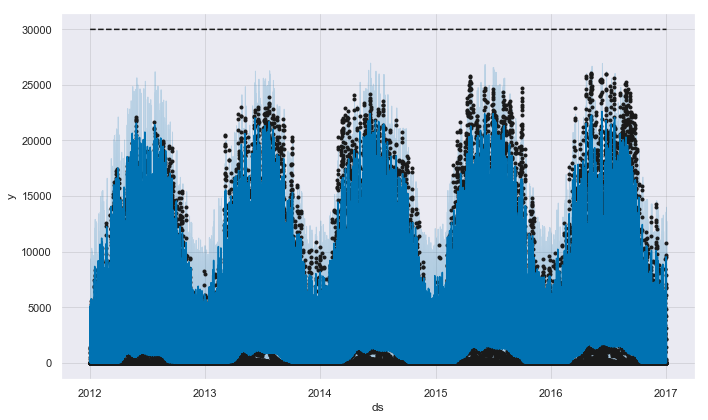

In [1121]:
fig = m.plot(fcst_solar_h)


In [ ]:
fig = m.plot_components(fcst_solar_h)

These results will be compared to the daily findings and discussed there.

#### Testing how the model does on some test data

In [1122]:
#Limit forcasted values to match test dataset date range
testing_fcst_solar_h = fcst_solar_h[fcst_solar_h['ds']>='2017-01-01 00:00:00']

In [1123]:
mean_absolute_error(solar_test['y'], testing_fcst_solar_h['yhat'])

635.8194012985683

In [1124]:
#preparing to merge
testing_fcst_solar_h = testing_fcst_solar_h['yhat']
test_results = solar_test['y']

In [1125]:
#reset the index so I can merge
test_results.reset_index(drop=True, inplace=True)
testing_fcst_solar_h.reset_index(drop=True, inplace=True)
#merging
test_results = pd.concat([test_results, testing_fcst_solar_h], axis=1)
test_results.fillna(0)
test_results.head(15)

,y,yhat
0,0.0,0.000000
1,0.0,0.000000
2,0.0,0.000000
3,0.0,0.000000
4,0.0,0.000000
5,0.0,79.631363
6,1.0,1532.413780
7,274.0,3275.766034
8,2083.0,5262.100792
9,4679.0,7159.412958


This model with some adjustments has actually fit the data pretty well. That mean absolute error isn't too bad either considering actual values range from 0 to 25,000. It seems this model could be further improved by better fitting the hourly changes as the sun is rising and setting. From what we have seen online, the bias is not to high here and it is not overfitting as it is doing better out of sample than in sample. 

let's see about the wind dataset

### Wind - Hourly

In [1126]:
wind_prophet_h.head()

,y,weather,ds
24,890.0,3.9290,2010-01-01 23:00:00
25,824.0,3.9374,2010-01-02 00:00:00
26,801.0,3.9878,2010-01-02 01:00:00
27,757.0,3.9901,2010-01-02 02:00:00
28,714.0,3.9727,2010-01-02 03:00:00


In [1127]:
#setting a cap and ceiling to contain confidence intervals
wind_prophet_h['floor'] = 0
wind_prophet_h['cap'] = 50000

In [1128]:
#defining my model
m = Prophet(changepoint_prior_scale=0.01, growth='linear', interval_width=0.95
           ).add_seasonality(
            name='hourly',
            period=1,
            fourier_order=50
            )
m.add_regressor('weather')

In [1129]:
m.fit(wind_prophet_h)

Let's do some evaluating of the performance of our model using the MAPE score to adjust hyperparameters using cross validation again.

In [1130]:
df_cv_h_solar = cross_validation(m, initial='730 days', period='365 days', horizon = '180 days')
df_cv_h_solar.head()

INFO:fbprophet:Making 5 forecasts with cutoffs between 2012-07-05 23:00:00 and 2016-07-04 23:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-07-06 00:00:00,3419.052319,-3192.999738,10518.497501,2840.0,2012-07-05 23:00:00
1,2012-07-06 01:00:00,3325.480602,-3736.903570,10336.213979,2553.0,2012-07-05 23:00:00
2,2012-07-06 02:00:00,3242.269041,-3389.554399,10055.087995,2333.0,2012-07-05 23:00:00
3,2012-07-06 03:00:00,3152.733653,-3908.250046,9189.186420,2175.0,2012-07-05 23:00:00
4,2012-07-06 04:00:00,3130.743088,-3704.339112,10680.808073,2088.0,2012-07-05 23:00:00


In [1131]:
#Let's look at the mape to see how far off from the real values we were for our estimates in cross validation
df_p = performance_metrics(df_cv_h_solar)
df_p.describe()

,horizon,mse,rmse,mae,mape,coverage
count,19446,1.944600e+04,19446.000000,19446.000000,19446.000000,19446.000000
mean,99 days 00:29:21.308238,2.467699e+07,4803.095290,3723.494564,1.447450,0.897916
std,46 days 18:19:31.044922,1.337621e+07,1267.811933,1043.591832,0.166084,0.084836
min,18 days 00:00:00,9.472510e+06,3077.744299,2420.104122,1.045635,0.663426
25%,58 days 13:00:00,1.510417e+07,3886.408103,2926.423126,1.311385,0.867593
50%,99 days 01:00:00,1.780053e+07,4219.067566,3320.498336,1.449640,0.937500
75%,139 days 12:00:00,3.583699e+07,5986.400812,4204.719551,1.574579,0.955093
max,180 days 00:00:00,5.555881e+07,7453.778272,6196.583922,1.833363,0.982407


We were able to now tune our model to get the best MAPE score. We will now run this through our test dataset and visualize our model to see how we did

In [1132]:
#I am going to make the future dataframe from my test dataframe so I can test against the same days actuals later
#This involve merging my test date range and data onto my training date so I can graph it all too
future = wind_test
future = pd.concat([wind_prophet_h, future], axis=0)
future = future.drop(['y'], axis=1)
future['floor'] = 0
future['cap'] = 50000
#Let's just look at it to make sure it connected properly
future.tail(30)

,cap,ds,floor,weather
61362,50000,2016-12-31 18:00:00,0,3.0336
61363,50000,2016-12-31 19:00:00,0,3.0919
61364,50000,2016-12-31 20:00:00,0,3.1371
61365,50000,2016-12-31 21:00:00,0,3.1763
61366,50000,2016-12-31 22:00:00,0,3.2729
61367,50000,2016-12-31 23:00:00,0,3.3321
61368,50000,2017-01-01 00:00:00,0,3.3939
61369,50000,2017-01-01 01:00:00,0,3.4352
61370,50000,2017-01-01 02:00:00,0,3.4240
61371,50000,2017-01-01 03:00:00,0,3.4480


In [1133]:
#Let's make some predictions
fcst_wind = m.predict(future)

In [1134]:
#Similar to last time, since values for yhat below zero are not realistic, I will just clip those values at a low of 0
fcst_solar_h['yhat'] = fcst_solar_h['yhat'].clip(0, 60000)
fcst_solar_h['yhat_lower'] = fcst_solar_h['yhat_lower'].clip(0, 60000)

In [1135]:
fcst_wind.tail()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,hourly,hourly_lower,hourly_upper,weather,weather_lower,weather_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
61356,2017-01-01 19:00:00,7400.046230,50000,4736.639039,22162.997362,7400.046230,7400.046230,6028.668437,6028.668437,6028.668437,116.012693,116.012693,116.012693,121.000551,121.000551,121.000551,2659.190328,2659.190328,2659.190328,121.000551,121.000551,121.000551,163.736686,163.736686,163.736686,2968.728179,2968.728179,2968.728179,0.0,0.0,0.0,13428.714667
61357,2017-01-01 20:00:00,7400.115701,50000,4315.696067,22588.978967,7400.115701,7400.115701,6143.035714,6143.035714,6143.035714,136.980992,136.980992,136.980992,224.593417,224.593417,224.593417,2682.971545,2682.971545,2682.971545,224.593417,224.593417,224.593417,134.703615,134.703615,134.703615,2963.786146,2963.786146,2963.786146,0.0,0.0,0.0,13543.151416
61358,2017-01-01 21:00:00,7400.185173,50000,4364.165565,22298.508273,7400.185173,7400.185173,6057.594872,6057.594872,6057.594872,134.973550,134.973550,134.973550,237.091216,237.091216,237.091216,2620.999579,2620.999579,2620.999579,237.091216,237.091216,237.091216,105.710113,105.710113,105.710113,2958.820415,2958.820415,2958.820415,0.0,0.0,0.0,13457.780045
61359,2017-01-01 22:00:00,7400.254644,50000,5105.509284,22818.660679,7400.254644,7400.254644,6143.545674,6143.545674,6143.545674,117.142820,117.142820,117.142820,408.588789,408.588789,408.588789,2587.002700,2587.002700,2587.002700,408.588789,408.588789,408.588789,76.980258,76.980258,76.980258,2953.831106,2953.831106,2953.831106,0.0,0.0,0.0,13543.800318
61360,2017-01-01 23:00:00,7400.324115,50000,4308.894488,22546.945159,7400.324115,7400.324115,6093.218322,6093.218322,6093.218322,95.394418,95.394418,95.394418,465.662071,465.662071,465.662071,2534.612001,2534.612001,2534.612001,465.662071,465.662071,465.662071,48.731493,48.731493,48.731493,2948.818338,2948.818338,2948.818338,0.0,0.0,0.0,13493.542437


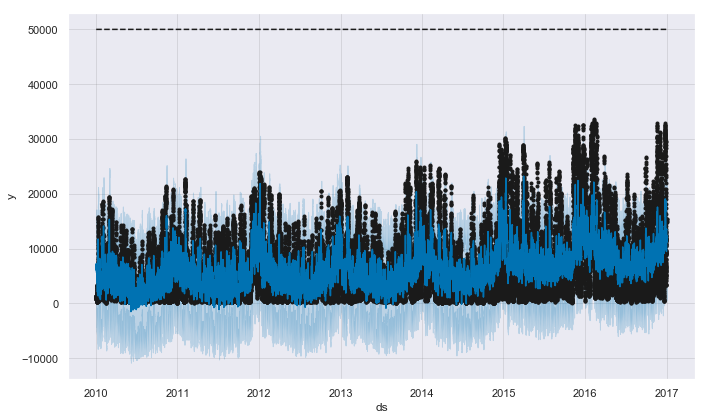

In [1136]:
fig = m.plot(fcst_wind)

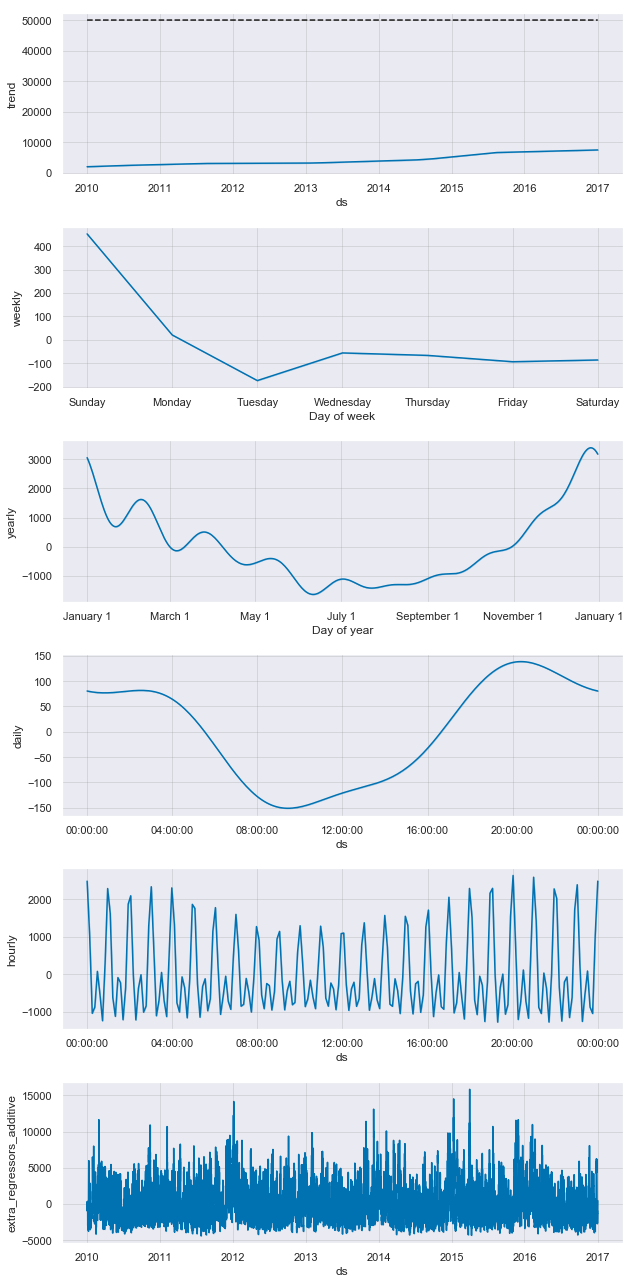

In [1143]:
fig = m.plot_components(fcst_wind)

These results will be compared to the daily components and discussed there

#### Testing how this model does on the test data

In [1137]:
testing_fcst_wind_h = fcst_wind[fcst_wind['ds']>='2017-01-01 00:00:00']

In [1138]:
shape(testing_fcst_wind_h)

(24, 32)

In [1139]:
print('{}%'.format(mean_absolute_percentage_error(wind_test['y'], testing_fcst_wind_h['yhat'])))

18.404210880235116%


In [1140]:
#Let's also use MAE to compare to previous model
mean_absolute_error(wind_test['y'], testing_fcst_wind_h['yhat'])

2354.2569920308174

In [1141]:
#preparing to merge
testing_fcst_wind_h = testing_fcst_wind_h['yhat']
test_results = wind_test['y']

In [1142]:
#reset the index so I can merge
test_results.reset_index(drop=True, inplace=True)
testing_fcst_wind_h.reset_index(drop=True, inplace=True)
#merging
test_results = pd.concat([test_results, testing_fcst_wind_h], axis=1)
test_results.fillna(0)
test_results.head(12)

,y,yhat
0,15363.0,12458.262437
1,15080.0,12451.609531
2,14731.0,12404.136042
3,14865.0,12409.603703
4,15254.0,12336.888574
5,15904.0,12144.761125
6,15903.0,11808.620476
7,15816.0,11606.970063
8,15722.0,11784.622765
9,14505.0,11803.908507


This seems to have actually worked pretty well. Adding the extra regressor of weather took my mean average % error down from about 8000% to 18%. It doesn't seem to have fitted as well as the solar model however. There is room in this estimate to remove some bias from the results. There is no evidence of high variance either as our model actually performed better out of sample. Future steps for tuning would involve improve the fitting of our model by adding even more trends.

Overall, I would say that this forecasts are fairly good and would recommend but not customer facing. There is definitely still work to be done probably with more weather data to get our model to fit better. There was no evidence of overfitting in either model but some small bias. The confidence interval is especially valuable in getting a probabilistic estimate of where renewable energy production will be for the next day. 

## Long Term Forecasts - Daily

### Wind - Daily

In [1038]:
#setting a cap and ceiling to contain confidence intervals
wind_prophet_d['floor'] = 0
wind_prophet_d['cap'] = 1000000

In [1039]:
#Let's define our model that we will adjust
m_w_d = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=False,
        growth='linear',
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.01
        ).add_seasonality(
            name='monthly',
            period=30.5,
            fourier_order=40
        ).add_seasonality(
            name='daily',
            period=1,
            fourier_order=1
        ).add_seasonality(
            name='weekly',
            period=7,
            fourier_order=1
        ).add_seasonality(
            name='yearly',
            period=365.25,
            fourier_order=5)
m_w_d.fit(wind_prophet_d)

Let's do some evaluating of the performance of our model using the MAPE score to adjust hyperparameters using cross validation again.

In [1040]:
df_cv_d_wind = cross_validation(m_w_d, initial='730 days', period='180 days', horizon = '365 days')
df_cv_d_wind.tail()

INFO:fbprophet:Making 7 forecasts with cutoffs between 2012-06-17 00:00:00 and 2015-06-02 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
2550,2016-05-28,145908.303188,16685.496522,255086.964926,85468.0,2015-06-02
2551,2016-05-29,162957.772683,39653.427483,284358.268532,163103.0,2015-06-02
2552,2016-05-30,174730.452343,58796.042659,308809.695402,246019.0,2015-06-02
2553,2016-05-31,152447.370780,34948.282993,276960.737555,106179.0,2015-06-02
2554,2016-06-01,142577.667138,27246.606954,267127.873214,5412.0,2015-06-02


In [1041]:
#Let's look at the mape to see how far off from the real values we were for our estimates in cross validation
df_p = performance_metrics(df_cv_d_wind)
df_p.describe()

,horizon,mse,rmse,mae,mape,coverage
count,2301,2.301000e+03,2301.000000,2301.000000,2301.000000,2301.000000
mean,201 days 03:25:16.036505,1.573033e+10,124773.177526,93237.823922,1.227468,0.708198
std,94 days 21:53:48.351024,3.198979e+09,12729.978806,8504.400948,0.133071,0.041660
min,37 days 00:00:00,9.781860e+09,98903.286010,77838.114297,0.941362,0.619608
25%,119 days 00:00:00,1.329134e+10,115288.063113,86667.663192,1.133699,0.674510
50%,201 days 00:00:00,1.513050e+10,123006.090487,91739.322531,1.237915,0.713725
75%,283 days 00:00:00,1.867955e+10,136673.147472,100880.152437,1.331579,0.745098
max,365 days 00:00:00,2.273582e+10,150784.011465,111151.966831,1.499113,0.788235


From this we were able to adjust and find our best hyperparameters which are now incorporated into our model. Now let's see how this performs against our test dataset and look at the visualizations

In [1042]:
# I am going to put the cap and floor in again to try control the confidence interval
future = m_w_d.make_future_dataframe(periods=642, freq='D')
future['floor'] = 0
future['cap'] = 1000000

In [1043]:
fcst_wind_d = m_w_d.predict(future)

In [1044]:
#Similar to last time, since values for yhat and the confidence interval below zero are not realistic, 
#I will just clip those values at a low of 0
fcst_wind_d['yhat_lower'] = fcst_wind_d['yhat_lower'].clip(0, 1000000)

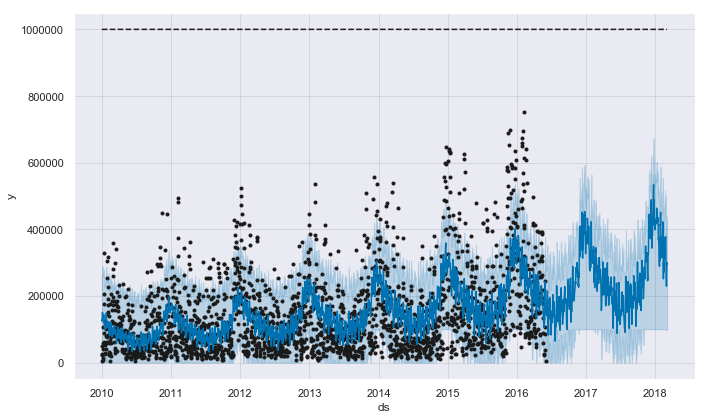

In [1045]:
fig = m_w_d.plot(fcst_wind_d)

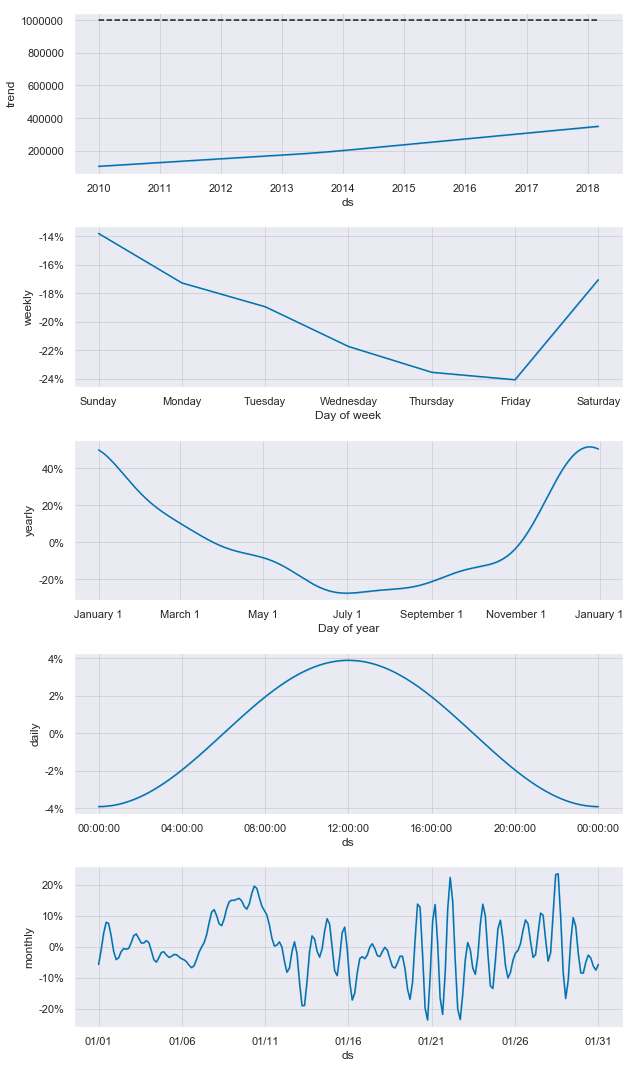

In [1144]:
fig = m_w_d.plot_components(fcst_wind_d)


These charts are very useful in identifying general trends in our data. Obviously some of the charts are not a causal relationship such as the day of the week on wind production. The yearly and daily trends of importance however. Generally as the sun comes up, air is warmed up and different relative temperatures creates pressure differences and ultimately wind. We see this relationship in the data where wind energy production is highest around noon. Additionally, since this is Germany in the northern hemisphere, summer is in the middle of the calendar year. In this data we see that summer is correlated with lower wind production, possibly because with everything already being some warm there are not as many pockets of differential pressure. This is additionally validated in comparing to the hourly components.

#### Comparing to test data

In [1047]:
testing_fcst_wind_d = fcst_wind_d[fcst_wind_d['ds']>'2016-06-01 00:00:00']

print('{}%'.format(mean_absolute_percentage_error(wind_test_d['y'], testing_fcst_wind_d['yhat'])))

97.60554476918828%


In [1048]:
#Let's also use MAE to compare to previous model
mean_absolute_error(wind_test_d['y'], testing_fcst_wind_d['yhat'])

137895.55532237916

In [1049]:
#preparing to merge into one dataset to compare results
testing_fcst_wind_d = testing_fcst_wind_d['yhat']
test_results = wind_test_d['y']

#reset the index so I can merge
test_results.reset_index(drop=True, inplace=True)
testing_fcst_wind_d.reset_index(drop=True, inplace=True)
#merging
test_results = pd.concat([test_results, testing_fcst_wind_d], axis=1)
test_results.head(12)

,y,yhat
0,108363.0,172452.350662
1,102326.0,144352.565025
2,54248.0,171262.744686
3,51030.0,158910.716105
4,69562.0,154024.936049
5,48539.0,139695.699087
6,162731.0,153481.649403
7,100748.0,160402.057093
8,141588.0,183243.549513
9,43853.0,214095.864725


This model has accomplished what it was meant to accomplish. We did not expect a perfect fit to the data but rather some insight into yearly and general trends since we have no way to predict a year into the future very well using weather data. There is definitely room for this model to be improved in terms of better fitting the data. The confidence interval is probably the most beneficial insight from this model in predicting with a probability where wind production will be which is influenced by new wind turbine construction. 

### Solar - Daily
Let's first set up the dataset and then perform cross validation on the data. After that a model will be run with the optimal change_point value

In [1050]:
#setting a cap and ceiling to contain confidence intervals
solar_prophet_d['floor'] = 0
solar_prophet_d['cap'] = 300000

In [1051]:
#Let's define our model that we will adjust
m_solar_d = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=False,
        growth='linear',
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.01
        ).add_seasonality(
            name='monthly',
            period=30.5,
            fourier_order=5
        ).add_seasonality(
            name='daily',
            period=1,
            fourier_order=20
        ).add_seasonality(
            name='weekly',
            period=7,
            fourier_order=5
        ).add_seasonality(
            name='yearly',
            period=365.25,
            fourier_order=20)
m_solar_d.fit(solar_prophet_d)

In [1052]:
df_cv_d_solar = cross_validation(m_solar_d, initial='730 days', period='180 days', horizon = '365 days')
df_cv_d_solar.tail()

INFO:fbprophet:Making 3 forecasts with cutoffs between 2014-06-07 00:00:00 and 2015-06-02 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
1090,2016-05-28,162195.337359,129220.451346,195592.587800,160593.0,2015-06-02
1091,2016-05-29,166713.344487,130214.938414,201368.596273,124929.0,2015-06-02
1092,2016-05-30,166906.497974,134147.372474,201636.069493,121137.0,2015-06-02
1093,2016-05-31,159222.781164,127575.755793,193076.250599,141406.0,2015-06-02
1094,2016-06-01,162750.104251,129858.246779,195515.367828,1.0,2015-06-02


In [1053]:
#Let's look at the mape to see how far off from the real values we were for our estimates in cross validation
df_p = performance_metrics(df_cv_d_solar)
df_p.describe()

,horizon,mse,rmse,mae,mape,coverage
count,987,9.870000e+02,987.000000,987.000000,987.000000,987.000000
mean,201 days 00:00:00,9.551730e+08,30497.856676,24020.171210,1.951704,0.745406
std,95 days 00:31:26.064933,3.010085e+08,5007.908168,5066.007107,47.522015,0.106973
min,37 days 00:00:00,4.277830e+08,20682.916681,15415.603824,0.286947,0.486239
25%,119 days 00:00:00,6.762620e+08,26005.025910,18724.969910,0.379393,0.665138
50%,201 days 00:00:00,9.861369e+08,31402.816800,24803.386001,0.443723,0.752294
75%,283 days 00:00:00,1.174078e+09,34264.820541,27181.554660,0.498056,0.853211
max,365 days 00:00:00,1.648324e+09,40599.556181,35204.963445,1493.414497,0.917431


In [1054]:
future = m_solar_d.make_future_dataframe(periods=642, freq='D')
future['floor'] = 0
future['cap'] = 300000

In [1055]:
fcst_solar_d = m_solar_d.predict(future)

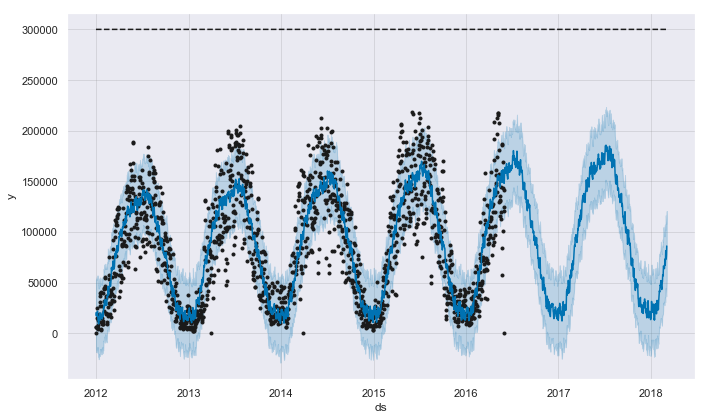

In [1056]:
fig = m_solar_d.plot(fcst_solar_d)

We are able to get a pretty good confidence interval fit around these values. There seems to be a lot less random variation in the data for solar power generation than wind overall. It is interesting too that there is more variation and thus uncertainty in our results in the summer than fall, winter, and spring

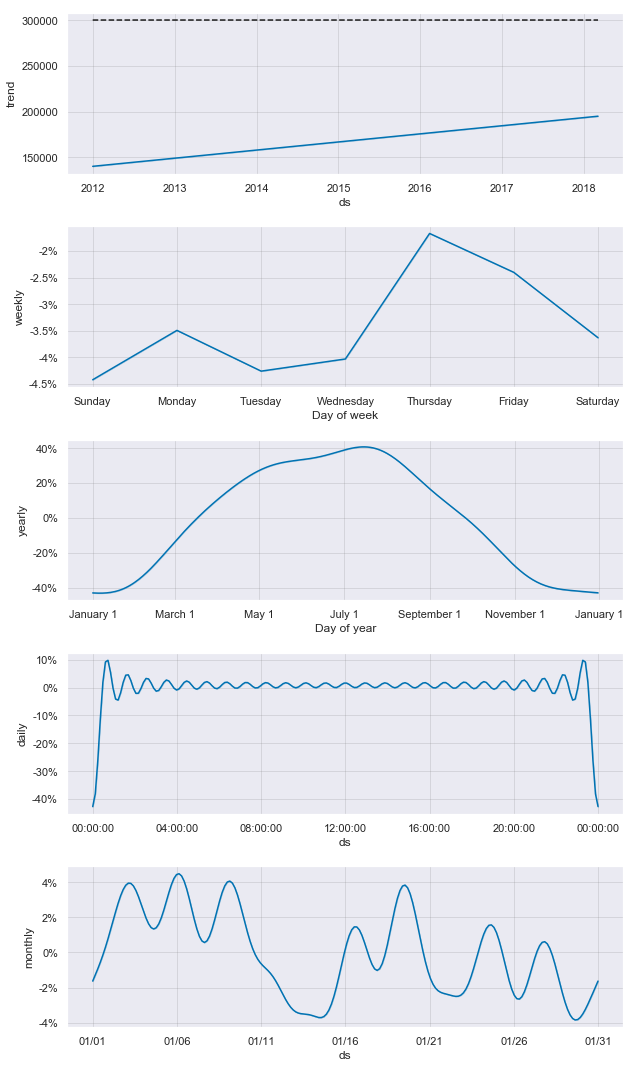

In [1057]:
fig = m_solar_d.plot_components(fcst_solar_d)

Again, these charts are very useful in identifying general trends in our data. The most useuful charts here are the trend and yearly plots which show solar power generation is obviously higher in the summer and that it is growing. This is additionally validated in comparing to the hourly components.

#### Compare against test data

In [1058]:
testing_fcst_solar_d = fcst_solar_d[fcst_solar_d['ds']>'2016-06-01 00:00:00']
#solar_test_d['y'] = solar_test_d['y'].replace(0.0, 1)
print('{}%'.format(mean_absolute_percentage_error(solar_test_d['y'], testing_fcst_solar_d['yhat'])))

inf%


In [1061]:
#Let's also use MAE to compare to previous model
mean_absolute_error(wind_test_d['y'], testing_fcst_solar_d['yhat'])

197248.37292248875

In [1062]:
#preparing to merge into one dataset to compare results
testing_fcst_solar_d = testing_fcst_solar_d['yhat']
test_results = solar_test_d['y']

#reset the index so I can merge
test_results.reset_index(drop=True, inplace=True)
testing_fcst_solar_d.reset_index(drop=True, inplace=True)
#merging
test_results = pd.concat([test_results, testing_fcst_solar_d], axis=1)
test_results.head(12)

,y,yhat
0,120895.0,159104.083779
1,143213.0,163663.210257
2,173422.0,163513.998752
3,176637.0,158224.059702
4,217347.0,163099.266685
5,214927.0,163782.541494
6,160187.0,158504.185887
7,155237.0,165851.746733
8,220844.0,167476.605712
9,134774.0,159792.617207


Again, this model has accomplished what it was meant to accomplish. We did not expect a perfect fit to the data but rather some insight into yearly and general trends since we have no way to predict a year into the future very well using weather data. There is definitely room for this model to be improved in terms of better fitting the data. The confidence interval is probably the most beneficial insight from this model in predicting with a probability where wind production will be in terms of the general trend. 

### Combining Daily Solar and Wind Forecasts for Analysis

In [1064]:
solar_names = ['solar_%s' % column for column in fcst_solar_d.columns]
wind_names = ['wind_%s' % column for column in fcst_wind_d.columns]
merge_solar_forecast = fcst_solar_d.copy()
merge_wind_forecast = fcst_wind_d.copy()
merge_solar_forecast.columns = solar_names
merge_wind_forecast.columns = wind_names
forecast = pd.merge(merge_solar_forecast, merge_wind_forecast, how = 'inner', left_on = 'solar_ds', right_on = 'wind_ds')
forecast = forecast.rename(columns={'solar_ds': 'Date'}).drop('wind_ds', axis=1)
forecast.head()

,Date,solar_trend,solar_cap,solar_yhat_lower,solar_yhat_upper,solar_trend_lower,solar_trend_upper,solar_daily,solar_daily_lower,solar_daily_upper,solar_monthly,solar_monthly_lower,solar_monthly_upper,solar_multiplicative_terms,solar_multiplicative_terms_lower,solar_multiplicative_terms_upper,solar_weekly,solar_weekly_lower,solar_weekly_upper,solar_yearly,solar_yearly_lower,solar_yearly_upper,solar_additive_terms,solar_additive_terms_lower,solar_additive_terms_upper,solar_yhat,wind_trend,wind_cap,wind_yhat_lower,wind_yhat_upper,wind_trend_lower,wind_trend_upper,wind_daily,wind_daily_lower,wind_daily_upper,wind_monthly,wind_monthly_lower,wind_monthly_upper,wind_multiplicative_terms,wind_multiplicative_terms_lower,wind_multiplicative_terms_upper,wind_weekly,wind_weekly_lower,wind_weekly_upper,wind_yearly,wind_yearly_lower,wind_yearly_upper,wind_additive_terms,wind_additive_terms_lower,wind_additive_terms_upper,wind_yhat
0,2011-12-31,140241.837647,300000,-15118.282766,53075.501400,140241.837647,140241.837647,-0.427245,-0.427245,-0.427245,0.038438,0.038438,0.038438,-0.855131,-0.855131,-0.855131,-0.036341,-0.036341,-0.036341,-0.429984,-0.429984,-0.429984,0.0,0.0,0.0,20316.649129,150620.457447,1000000,63491.041489,322727.077631,150620.457447,150620.457447,-0.039002,-0.039002,-0.039002,0.015251,0.015251,0.015251,0.311874,0.311874,0.311874,-0.170621,-0.170621,-0.170621,0.506247,0.506247,0.506247,0.0,0.0,0.0,197595.033029
1,2012-01-01,140266.098593,300000,-18350.919942,53909.700635,140266.098593,140266.098593,-0.427245,-0.427245,-0.427245,0.025348,0.025348,0.025348,-0.876667,-0.876667,-0.876667,-0.044253,-0.044253,-0.044253,-0.430517,-0.430517,-0.430517,0.0,0.0,0.0,17299.385592,150683.031913,1000000,70107.652412,350374.222969,150683.031913,150683.031913,-0.039002,-0.039002,-0.039002,0.019340,0.019340,0.019340,0.344833,0.344833,0.344833,-0.138144,-0.138144,-0.138144,0.502639,0.502639,0.502639,0.0,0.0,0.0,202643.583266
2,2012-01-02,140290.359538,300000,-16358.476487,53227.540086,140290.359538,140290.359538,-0.427245,-0.427245,-0.427245,0.016556,0.016556,0.016556,-0.876640,-0.876640,-0.876640,-0.034957,-0.034957,-0.034957,-0.430995,-0.430995,-0.430995,0.0,0.0,0.0,17306.204321,150745.606379,1000000,55287.262156,328437.170570,150745.606379,150745.606379,-0.039002,-0.039002,-0.039002,-0.016713,-0.016713,-0.016713,0.269971,0.269971,0.269971,-0.172840,-0.172840,-0.172840,0.498525,0.498525,0.498525,0.0,0.0,0.0,191442.610436
3,2012-01-03,140314.620483,300000,-17362.794113,55528.887089,140314.620483,140314.620483,-0.427245,-0.427245,-0.427245,0.043806,0.043806,0.043806,-0.857479,-0.857479,-0.857479,-0.042633,-0.042633,-0.042633,-0.431407,-0.431407,-0.431407,0.0,0.0,0.0,19997.763598,150808.180845,1000000,48229.281540,319696.289194,150808.180845,150808.180845,-0.039002,-0.039002,-0.039002,-0.036336,-0.036336,-0.036336,0.229023,0.229023,0.229023,-0.189568,-0.189568,-0.189568,0.493929,0.493929,0.493929,0.0,0.0,0.0,185346.679513
4,2012-01-04,140338.881428,300000,-18941.616445,53077.472234,140338.881428,140338.881428,-0.427245,-0.427245,-0.427245,0.023875,0.023875,0.023875,-0.875457,-0.875457,-0.875457,-0.040343,-0.040343,-0.040343,-0.431743,-0.431743,-0.431743,0.0,0.0,0.0,17478.244333,150870.755311,1000000,44366.317215,322675.975253,150870.755311,150870.755311,-0.039002,-0.039002,-0.039002,-0.036812,-0.036812,-0.036812,0.195597,0.195597,0.195597,-0.217462,-0.217462,-0.217462,0.488873,0.488873,0.488873,0.0,0.0,0.0,180380.635313


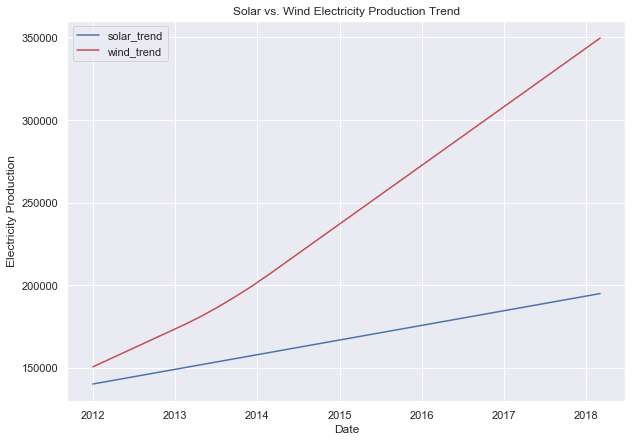

In [1065]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['solar_trend'], 'b-')
plt.plot(forecast['Date'], forecast['wind_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Electricity Production')
plt.title('Solar vs. Wind Electricity Production Trend');

Here we compare the solar and wind production trends in Germany. Obviously wind is producing a lot more power and at an increasing rate compared to solar. Some background on the countries building of wind turbines and future wind turbine construction could add significant value

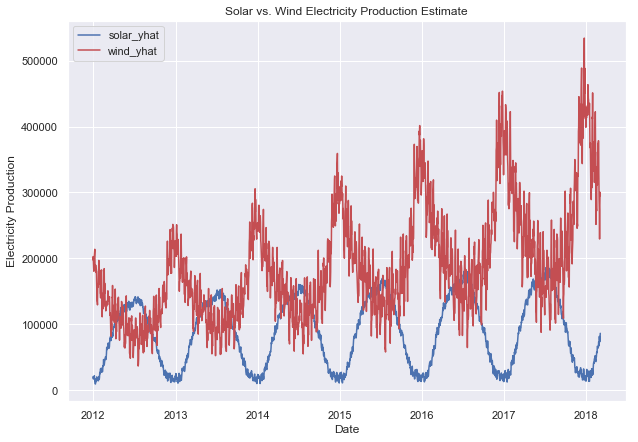

In [1066]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['solar_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['wind_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Electricity Production')
plt.title('Solar vs. Wind Electricity Production Estimate');

Again we see that wind is the dominant source of renewable energy here in Germany. This plot is especially useful however to show that even though wind is dominant, solar energy should not be ignored since each source of energy is at its peak at different times of the year. Solar panels can compensate for low wind generation during the summer season and the opposite is also true for the winter time. 

fig, ax = plt.subplots(10,1, figsize = (14, 20))
ax = ax.ravel()
j = 0


for i in [0.001, 0.005, 0.01, 0.05, 0.10]:
    m_w = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=False,
        growth='linear',
        seasonality_mode='multiplicative',
        changepoint_prior_scale=30
        ).add_seasonality(
            name='monthly',
            period=30.5,
            fourier_order=12
        ).add_seasonality(
            name='daily',
            period=1,
            fourier_order=20
        ).add_seasonality(
            name='weekly',
            period=7,
            fourier_order=20
        ).add_seasonality(
            name='yearly',
            period=365.25,
            fourier_order=20)
    #fit the prophet model on the data
    m_w.fit(wind_prophet_d)
    # make a dataframe of the next two years 
    future = m_w.make_future_dataframe(periods=365)
    #predict on this future dataframe
    forecast = m_w.predict(future)
    # plot the forecast 
    fig = m_w.plot(forecast, ax = ax[j])
    ax[j].set_title('changepoint prior = ' + str(i))
    j += 1
    df_cv = cross_validation(m_w, initial='365 days', period='180 days', horizon = '365 days')
    df_p = performance_metrics(df_cv)
    fig = plot_cross_validation_metric(df_cv, metric='mape', ax = ax[j])
    ax[j].set_title(str(str(i) + ' Change Point Prior Mean Absolute Percentage Error'))
    ax[j].set_ylim(0,4)
    j += 1
    print(i)
    #print(pd.DataFrame(performance_metrics(df_cv)).head(2))
    print(pd.DataFrame(performance_metrics(df_cv).describe()))